In [1]:
# CELL 1 — PROJECT SETUP + DATA DOWNLOAD
# This cell:
# 1) Creates a clean project folder structure (like a real data scientist repo)
# 2) Downloads the Telco churn dataset into the /data folder (so later cells don't fail)

import pathlib
import pandas as pd

# ---- Create a professional project folder structure ----
BASE_DIR = pathlib.Path("churn_project")
DATA_DIR = BASE_DIR / "data"
SQL_DIR  = BASE_DIR / "sql"
OUT_DIR  = BASE_DIR / "outputs"
FIG_DIR  = OUT_DIR / "figures"

# Make the folders if they don't exist (exist_ok=True prevents errors if rerun)
for p in [DATA_DIR, SQL_DIR, OUT_DIR, FIG_DIR]:
    p.mkdir(parents=True, exist_ok=True)

# ---- Define where the CSV should live ----
CSV_PATH = DATA_DIR / "Telco-Customer-Churn.csv"

# ---- Download dataset from IBM public GitHub (no Kaggle login needed) ----
url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"

# Only download if we don't already have it
if not CSV_PATH.exists():
    !wget -q -O "{CSV_PATH}" "{url}"

print("CSV exists:", CSV_PATH.exists())
print("CSV path:", CSV_PATH)


CSV exists: True
CSV path: churn_project/data/Telco-Customer-Churn.csv


In [2]:
# CELL 2 — LOAD DATA + CLEAN TYPES + CREATE TARGET
# This cell:
# 1) Loads the CSV into a pandas DataFrame (table)
# 2) Converts TotalCharges to numeric (it sometimes contains blanks)
# 3) Creates churn target as 0/1
# 4) Drops the original "Churn" text column to avoid SQLite case-insensitive duplicate issues

import numpy as np
import pandas as pd

# ---- Load raw data ----
df_raw = pd.read_csv(CSV_PATH)
print("Raw shape:", df_raw.shape)
display(df_raw.head())

# ---- Work on a copy (keeps raw data intact) ----
df = df_raw.copy()

# ---- Convert TotalCharges to numeric; blanks become NaN ----
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# ---- Create binary churn target: Yes -> 1, No -> 0 ----
df["churn"] = (df["Churn"].astype(str).str.strip().str.lower() == "yes").astype(int)

# ---- Drop original "Churn" column ----
# Reason: SQLite treats "Churn" and "churn" as the same column name (case-insensitive),
# which can cause: OperationalError: duplicate column name: churn
df = df.drop(columns=["Churn"])

# ---- Quick data checks ----
print("\nMissing rate (top 8 columns):")
display(df.isna().mean().sort_values(ascending=False).head(8))

print("\nChurn rate (fraction of customers who left):", round(df["churn"].mean(), 3))


Raw shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes



Missing rate (top 8 columns):


,0
TotalCharges,0.001562
gender,0.000000
SeniorCitizen,0.000000
Partner,0.000000
customerID,0.000000
Dependents,0.000000
tenure,0.000000
MultipleLines,0.000000



Churn rate (fraction of customers who left): 0.265


In [ ]:
# CELL 3 — DATABASE STEP (SQL) + MODELING TABLE
# This cell:
# 1) Creates a SQLite database file (like a mini local database)
# 2) Writes the cleaned DataFrame into a table called telco_raw
# 3) Uses SQL to create a "modeling table" with selected fields and an engineered tenure_bucket feature
# 4) Reads that modeling table back into pandas as df_model

import sqlite3

# ---- Create/connect to a SQLite database file ----
DB_PATH = OUT_DIR / "churn.db"
con = sqlite3.connect(DB_PATH)

# ---- Write pandas DataFrame into SQL table "telco_raw" ----
# if_exists="replace" means reruns won't break; it overwrites the table
df.to_sql("telco_raw", con, if_exists="replace", index=False)

# ---- SQL script to build a clean modeling table ----
sql_build = """
DROP TABLE IF EXISTS telco_modeling;

CREATE TABLE telco_modeling AS
SELECT
  customerID,
  churn,
  tenure,
  MonthlyCharges,
  TotalCharges,

  -- Create a bucketed tenure category (easier to interpret than raw tenure)
  CASE
    WHEN tenure IS NULL THEN NULL
    WHEN tenure < 6 THEN '0-5'
    WHEN tenure < 12 THEN '6-11'
    WHEN tenure < 24 THEN '12-23'
    WHEN tenure < 48 THEN '24-47'
    ELSE '48+'
  END AS tenure_bucket,

  -- Categorical fields used by the model
  gender,
  SeniorCitizen,
  Partner,
  Dependents,
  PhoneService,
  MultipleLines,
  InternetService,
  OnlineSecurity,
  OnlineBackup,
  DeviceProtection,
  TechSupport,
  StreamingTV,
  StreamingMovies,
  Contract,
  PaperlessBilling,
  PaymentMethod
FROM telco_raw;
"""

# ---- Execute SQL ----
con.executescript(sql_build)

# ---- Save SQL to a file (optional but professional) ----
(SQL_DIR / "01_build_modeling_table.sql").write_text(sql_build)

# ---- Read modeling table into pandas ----
df_model = pd.read_sql_query("SELECT * FROM telco_modeling;", con)
con.close()

print("Modeling table shape:", df_model.shape)
display(df_model.head())


Modeling table shape: (7043, 22)


,customerID,churn,tenure,MonthlyCharges,TotalCharges,tenure_bucket,gender,SeniorCitizen,Partner,Dependents,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod
0,7590-VHVEG,0,1,29.85,29.85,0-5,Female,0,Yes,No,...,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check
1,5575-GNVDE,0,34,56.95,1889.50,24-47,Male,0,No,No,...,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check
2,3668-QPYBK,1,2,53.85,108.15,0-5,Male,0,No,No,...,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check
3,7795-CFOCW,0,45,42.30,1840.75,24-47,Male,0,No,No,...,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic)
4,9237-HQITU,1,2,70.70,151.65,0-5,Female,0,No,No,...,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check


In [ ]:
# CELL 4 — DATA VALIDATION
# This cell checks for common problems:
# 1) Duplicate customer IDs (should usually be 0)
# 2) Suspicious ranges for numeric columns
# 3) Missing value rates after building the modeling table

print("Duplicate customerID count:", df_model["customerID"].duplicated().sum())

display(df_model[["tenure", "MonthlyCharges", "TotalCharges"]].describe())

print("\nMissing rate (top 10 columns):")
display(df_model.isna().mean().sort_values(ascending=False).head(10))


Duplicate customerID count: 0


,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7032.000000
mean,32.371149,64.761692,2283.300441
std,24.559481,30.090047,2266.771362
min,0.000000,18.250000,18.800000
25%,9.000000,35.500000,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.850000,3794.737500
max,72.000000,118.750000,8684.800000



Missing rate (top 10 columns):


,0
TotalCharges,0.001562
customerID,0.000000
churn,0.000000
tenure,0.000000
MonthlyCharges,0.000000
tenure_bucket,0.000000
gender,0.000000
SeniorCitizen,0.000000
Partner,0.000000
Dependents,0.000000


,churn
Contract,
Month-to-month,0.427097
One year,0.112695
Two year,0.028319


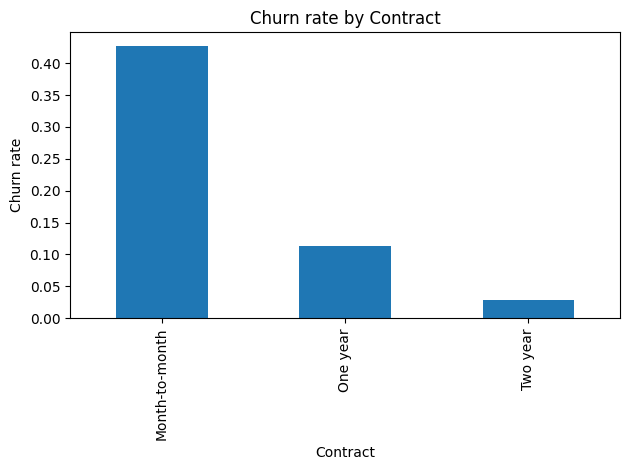

,churn
tenure_bucket,
0-5,0.542670
12-23,0.295129
24-47,0.208744
48+,0.096396
6-11,0.365330


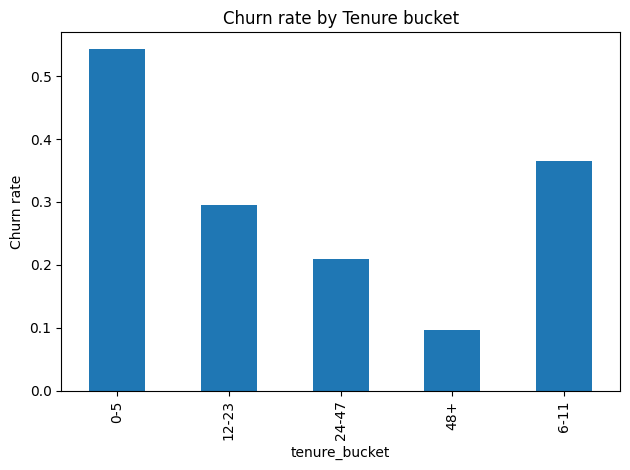

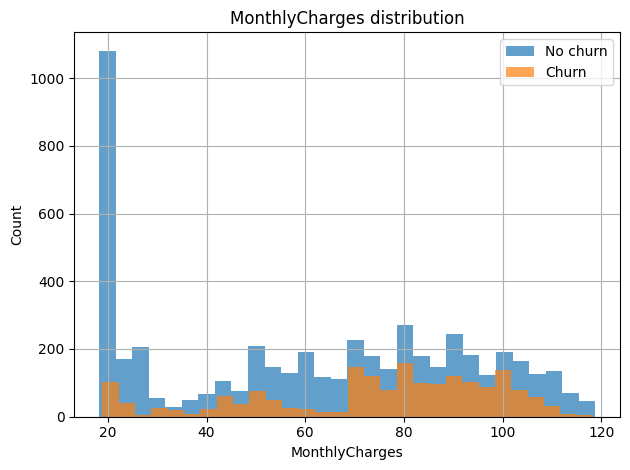

In [ ]:
# CELL 5 — EDA (EXPLORATORY DATA ANALYSIS)
# This cell makes 3 stakeholder-friendly views:
# 1) Which contract types churn the most?
# 2) Do newer customers churn more? (tenure bucket)
# 3) Are MonthlyCharges different for churners vs non-churners?

import matplotlib.pyplot as plt

# ---- Churn rate by contract ----
contract_churn = df_model.groupby("Contract")["churn"].mean().sort_values(ascending=False)
display(contract_churn)

plt.figure()
contract_churn.plot(kind="bar")
plt.title("Churn rate by Contract")
plt.ylabel("Churn rate")
plt.tight_layout()
plt.savefig(FIG_DIR / "churn_by_contract.png")
plt.show()

# ---- Churn rate by tenure bucket ----
tenure_churn = df_model.groupby("tenure_bucket")["churn"].mean()
display(tenure_churn)

plt.figure()
tenure_churn.plot(kind="bar")
plt.title("Churn rate by Tenure bucket")
plt.ylabel("Churn rate")
plt.tight_layout()
plt.savefig(FIG_DIR / "churn_by_tenure_bucket.png")
plt.show()

# ---- MonthlyCharges distribution (churn vs not churn) ----
plt.figure()
df_model[df_model["churn"] == 0]["MonthlyCharges"].hist(bins=30, alpha=0.7, label="No churn")
df_model[df_model["churn"] == 1]["MonthlyCharges"].hist(bins=30, alpha=0.7, label="Churn")
plt.title("MonthlyCharges distribution")
plt.xlabel("MonthlyCharges")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / "monthlycharges_hist.png")
plt.show()


In [ ]:
# CELL 6 — PREP FOR MACHINE LEARNING
# Models need:
# - Numeric inputs
# - No missing values
# - Categorical variables converted to numeric
#
# This cell:
# 1) Splits into X (features) and y (target)
# 2) Drops customerID (identifier, not predictive)
# 3) Builds preprocessing:
#    - numeric: fill missing with median
#    - categorical: fill missing with most common + one-hot encode
# 4) Splits into train and test sets

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
import numpy as np

TARGET = "churn"
ID_COL = "customerID"

X = df_model.drop(columns=[TARGET])
y = df_model[TARGET].astype(int)

# Drop identifier column
X = X.drop(columns=[ID_COL])

# Identify numeric vs categorical features
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = [c for c in X.columns if c not in numeric_features]

print("Numeric features:", numeric_features)
print("Categorical feature count:", len(categorical_features))

# Preprocessing pipeline:
# - Impute missing numeric values with median
# - Impute missing categorical values with most frequent
# - OneHotEncode categoricals to 0/1 columns
preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median"))
        ]), numeric_features),
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), categorical_features),
    ]
)

# Train/test split: stratify keeps churn proportion similar in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)


Numeric features: ['tenure', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen']
Categorical feature count: 16
Train size: (5634, 20) Test size: (1409, 20)


In [ ]:
# CELL 7 — TRAIN MODELS + EVALUATE
# We'll train:
# 1) Logistic Regression: interpretable baseline
# 2) HistGradientBoosting: usually stronger predictive performance on tabular data
#
# We evaluate using:
# - ROC AUC (ranking quality overall)
# - PR AUC (better for imbalanced datasets like churn)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import roc_auc_score, average_precision_score
import json

log_reg = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=2000))
])

hgb = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", HistGradientBoostingClassifier(
        learning_rate=0.05, max_depth=6, max_iter=400, random_state=42
    ))
])

# Fit models
log_reg.fit(X_train, y_train)
hgb.fit(X_train, y_train)

# Predict churn probabilities
proba_lr  = log_reg.predict_proba(X_test)[:, 1]
proba_hgb = hgb.predict_proba(X_test)[:, 1]

# Compute metrics
metrics = {
    "log_reg_roc_auc": float(roc_auc_score(y_test, proba_lr)),
    "log_reg_pr_auc":  float(average_precision_score(y_test, proba_lr)),
    "hgb_roc_auc":     float(roc_auc_score(y_test, proba_hgb)),
    "hgb_pr_auc":      float(average_precision_score(y_test, proba_hgb)),
}

print(metrics)

# Save metrics so results are reproducible and easy to share
(OUT_DIR / "metrics.json").write_text(json.dumps(metrics, indent=2))


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'log_reg_roc_auc': 0.8465292309282079, 'log_reg_pr_auc': 0.6558371618608069, 'hgb_roc_auc': 0.8290500917099384, 'hgb_pr_auc': 0.6342364088580438}


156

In [ ]:
# CELL 8 — DECISION THRESHOLD (OPERATIONS)
# The model outputs probabilities (0 to 1).
# The business needs a yes/no list: "Who should we contact?"
#
# We'll pick a threshold designed to achieve a target recall.
# Example: recall ~0.75 means we catch ~75% of actual churners.

from sklearn.metrics import precision_recall_curve, confusion_matrix, classification_report
import numpy as np

def pick_threshold_for_recall(y_true, y_proba, target_recall=0.75):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_proba)
    # precision_recall_curve returns arrays where thresholds is 1 shorter than precisions/recalls
    precisions, recalls = precisions[:-1], recalls[:-1]

    # Find thresholds where recall meets target
    mask = recalls >= target_recall

    if mask.sum() == 0:
        # If target recall is impossible, pick best recall available
        idx = np.argmax(recalls)
        return thresholds[idx], precisions[idx], recalls[idx]

    # Among thresholds meeting recall target, pick highest precision (less wasted outreach)
    idx = np.argmax(precisions[mask])
    return thresholds[mask][idx], precisions[mask][idx], recalls[mask][idx]

threshold, prec, rec = pick_threshold_for_recall(y_test.values, proba_hgb, target_recall=0.75)

print("Chosen threshold:", threshold)
print("Precision:", round(prec, 3), "Recall:", round(rec, 3))

# Convert probabilities into predicted labels using the threshold
y_pred = (proba_hgb >= threshold).astype(int)

print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred, digits=3))


Chosen threshold: 0.29642729842528
Precision: 0.541 Recall: 0.751

Confusion matrix:
 [[797 238]
 [ 93 281]]

Classification report:
               precision    recall  f1-score   support

           0      0.896     0.770     0.828      1035
           1      0.541     0.751     0.629       374

    accuracy                          0.765      1409
   macro avg      0.718     0.761     0.729      1409
weighted avg      0.802     0.765     0.775      1409



In [ ]:
# CELL 9 — INTERPRETATION (WHY CUSTOMERS CHURN)
# Logistic regression has coefficients:
# - Positive coefficient: increases churn risk
# - Negative coefficient: decreases churn risk (protective)
#
# Because we one-hot encoded categories, we first extract the expanded feature names,
# then pair them with the coefficients.

import numpy as np
import pandas as pd

# Get one-hot encoder and feature names from the preprocessing pipeline
ohe = log_reg.named_steps["preprocess"].named_transformers_["cat"].named_steps["onehot"]
cat_names = ohe.get_feature_names_out(categorical_features)

# Combine numeric feature names + one-hot feature names
feature_names = np.concatenate([numeric_features, cat_names])

# Extract coefficients
coefs = log_reg.named_steps["model"].coef_[0]

# Create a table and sort by coefficient value
coef_df = pd.DataFrame({"feature": feature_names, "coef": coefs}).sort_values("coef", ascending=False)

print("Top positive churn drivers:")
display(coef_df.head(15))

print("Top protective factors (reduce churn):")
display(coef_df.tail(15))

# Save to file so you can reference it later
coef_df.to_csv(OUT_DIR / "logreg_coefficients.csv", index=False)


Top positive churn drivers:


,feature,coef
41,Contract_Month-to-month,0.717673
4,tenure_bucket_0-5,0.595946
21,InternetService_Fiber optic,0.583496
48,PaymentMethod_Electronic check,0.226998
40,StreamingMovies_Yes,0.221971
37,StreamingTV_Yes,0.217012
23,OnlineSecurity_No,0.196077
32,TechSupport_No,0.170591
3,SeniorCitizen,0.153808
19,MultipleLines_Yes,0.141158


Top protective factors (reduce churn):


,feature,coef
38,StreamingMovies_No,-0.157899
14,Dependents_Yes,-0.171984
27,OnlineBackup_No internet service,-0.201996
39,StreamingMovies_No internet service,-0.201996
33,TechSupport_No internet service,-0.201996
24,OnlineSecurity_No internet service,-0.201996
22,InternetService_No,-0.201996
36,StreamingTV_No internet service,-0.201996
30,DeviceProtection_No internet service,-0.201996
5,tenure_bucket_12-23,-0.223008


In [ ]:
# CELL 10 — ACTIONABLE OUTPUT: WHO TO CONTACT + WHAT TO DO
# This creates a "retention target list":
# - Customer rows ranked by predicted churn risk
# - A simple suggested action playbook based on their profile

results = X_test.copy()
results["churn_true"] = y_test.values
results["churn_proba"] = proba_hgb
results["high_risk"] = (results["churn_proba"] >= threshold).astype(int)

# Simple rule-based recommendations (you can refine later)
def suggest_action(row):
    if row.get("Contract") == "Month-to-month" and row.get("tenure", 0) < 6:
        return "Onboarding check-in + proactive support"
    if row.get("Contract") == "Month-to-month" and row.get("MonthlyCharges", 0) > 80:
        return "Offer plan optimization / discount bundle"
    if row.get("TechSupport") == "No":
        return "Offer free TechSupport trial"
    return "Standard retention outreach"

results["suggested_action"] = results.apply(suggest_action, axis=1)

# Top 50 highest-risk customers
top50 = results.sort_values("churn_proba", ascending=False).head(50)

# Show top part of the list
display(top50[["churn_proba", "Contract", "tenure", "MonthlyCharges", "TechSupport", "suggested_action"]].head(20))

# Save list to CSV (this is a real deliverable)
top50.to_csv(OUT_DIR / "top_50_retention_targets.csv", index=False)
print("Saved:", OUT_DIR / "top_50_retention_targets.csv")


,churn_proba,Contract,tenure,MonthlyCharges,TechSupport,suggested_action
1731,0.975088,Month-to-month,1,69.60,No,Onboarding check-in + proactive support
809,0.972967,Month-to-month,1,69.55,No,Onboarding check-in + proactive support
2900,0.972846,Month-to-month,1,69.25,No,Onboarding check-in + proactive support
2631,0.971659,Month-to-month,7,99.25,No,Offer plan optimization / discount bundle
3682,0.970290,Month-to-month,1,69.10,No,Onboarding check-in + proactive support
1073,0.961900,Month-to-month,7,98.05,No,Offer plan optimization / discount bundle
2517,0.961373,Month-to-month,1,69.50,No,Onboarding check-in + proactive support
3822,0.957785,Month-to-month,6,94.05,No,Offer plan optimization / discount bundle
4678,0.954843,Month-to-month,2,94.20,No,Onboarding check-in + proactive support
2464,0.954803,Month-to-month,1,77.15,No,Onboarding check-in + proactive support


Saved: churn_project/outputs/top_50_retention_targets.csv


In [ ]:
# CELL 11 — FINAL REPORT (README)
# This creates a README.md summarizing the project like a real DS deliverable:
# - business goal
# - what you did
# - results
# - outputs
# - limitations

readme = f"""
# Telco Customer Churn Prediction (End-to-End)

## Business Problem
Predict which customers are likely to churn and identify churn drivers to guide retention actions.

## Data
Telco churn dataset (customer demographics, services, billing, churn label). Source: IBM-hosted CSV.

## Workflow
1. Loaded raw CSV and cleaned types (TotalCharges -> numeric)
2. Built a modeling table in SQLite via SQL
3. Validated data quality and performed targeted EDA
4. Trained two models:
   - Logistic Regression (interpretable baseline)
   - HistGradientBoosting (strong predictive model)
5. Selected an outreach threshold targeting ~0.75 recall for churners
6. Produced churn drivers and a top-50 outreach list with suggested actions

## Results (Test Set)
- Logistic Regression ROC AUC: {metrics["log_reg_roc_auc"]:.3f}, PR AUC: {metrics["log_reg_pr_auc"]:.3f}
- Gradient Boosting ROC AUC: {metrics["hgb_roc_auc"]:.3f}, PR AUC: {metrics["hgb_pr_auc"]:.3f}

## Key Outputs
- outputs/metrics.json
- outputs/logreg_coefficients.csv
- outputs/top_50_retention_targets.csv
- outputs/figures/*.png
- outputs/churn.db

## Recommendations
- Prioritize retention outreach for high-risk customers flagged by the model
- Focus offers on month-to-month customers, especially low-tenure and high-charge segments
- Consider TechSupport trial offers where absence correlates with churn

## Limitations
- Observational data (correlation != causation)
- Production use requires monitoring for drift and periodic retraining
"""

# Save README to the project folder
(BASE_DIR / "README.md").write_text(readme.strip())
print("Wrote:", BASE_DIR / "README.md")


Wrote: churn_project/README.md
